## This notebook is for LRG specific results from SV3 LSS catalogs

In [3]:
import numpy as np
import fitsio
from matplotlib import pyplot as plt
import os

In [5]:
ff = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/LRGAlltiles_full.dat.fits')

total number of unique reachable LRG targets is 108494
total number of unique observed LRG targets is 92679
total number of unique LRG targets with good redshifts is 91321
targeting completeness is 0.8542315704094235
redshift success rate is 0.9853472739239741


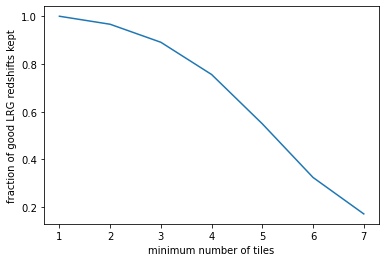

In [16]:
print('total number of unique reachable LRG targets is '+str(len(ff)))
wo = ff['LOCATION_ASSIGNED'] == 1
print('total number of unique observed LRG targets is '+str(len(ff[wo])))
wz = ff['ZWARN'] == 0
print('total number of unique LRG targets with good redshifts is '+str(len(ff[wz])))
print('targeting completeness is '+str(len(ff[wo])/len(ff)))
print('redshift success rate is '+str(len(ff[wz])/len(ff[wo])))
ngl = [len(ff[wz])]
ntm = [1]
for nt in range(1,7):
    wt = ff['NTILE'] > nt
    ntm.append(nt+1)
    ngl.append(len(ff[wz&wt]))
plt.plot(ntm,np.array(ngl)/len(ff[wz]))
plt.xlabel('minimum number of tiles')
plt.ylabel('fraction of good LRG redshifts kept')
plt.show()


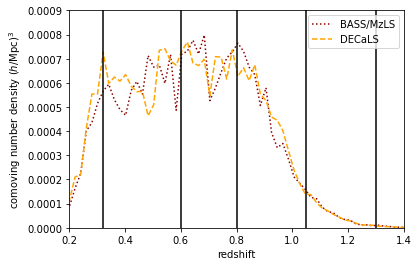

In [25]:
#plot n(z)
nz = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/LRG_N_nz.dat').transpose()
plt.plot(nz[0],nz[3],':',color='darkred',label='BASS/MzLS')
nz = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/LRG_S_nz.dat').transpose()
plt.plot(nz[0],nz[3],'--',color='orange',label='DECaLS')
plt.legend()
plt.xlim(0.2,1.4)
plt.ylim(0,0.0009)
xl = [0.32,0.32]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [0.6,0.6]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [0.8,0.8]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [1.05,1.05]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [1.3,1.3]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [1.6,1.6]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
plt.xlabel('redshift')
plt.ylabel(r'comoving number density ($h$/Mpc)$^3$')
plt.show()

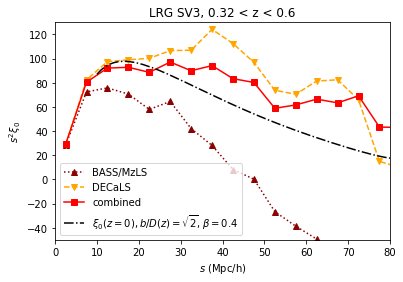

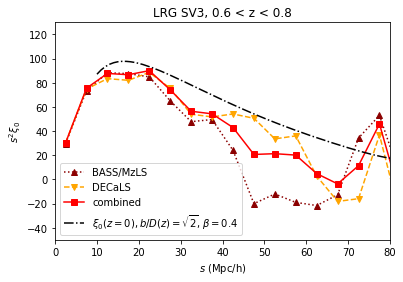

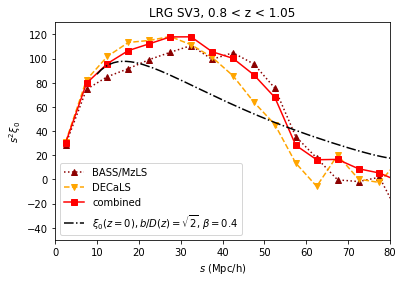

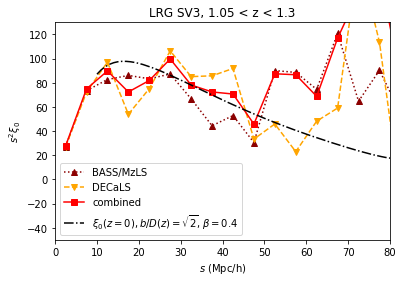

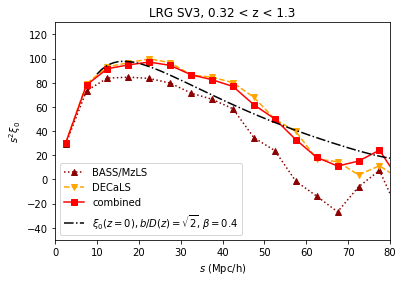

In [20]:
zl = [0.32,0.6,0.8,1.05,1.3]
for i in range(0,len(zl)):
    if i == len(zl)-1:
        zmin=zl[0]
        zmax=zl[-1]
    else:
        zmin = zl[i]
        zmax = zl[i+1]

    xils = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRG_S'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xil = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRG'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xiln = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRG_N'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xil[0],xil[0]**2.*xiln[1],'^:',color='darkred',label='BASS/MzLS')
    plt.plot(xil[0],xil[0]**2.*xils[1],'v--',color='orange',label='DECaLS')
    plt.plot(xil[0],xil[0]**2.*xil[1],'s-r',label='combined')
    xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    plt.plot(xilin[0],xilin[0]**2.*xilin[1]*2,'k-.',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{2},\beta=0.4$')

    plt.title('LRG SV3, '+str(zmin)+' < z < '+str(zmax))
    plt.xlim(0,80)
    plt.ylim(-50,130)
    plt.xlabel(r'$s$ (Mpc/h)')
    plt.ylabel(r'$s^2\xi_0$')
    plt.legend()
    plt.show()

## clustering looks kind of funky...not sure what is going on